# Tabular Playground Series - Apr 2021

# Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
TARGET = 'Survived'

DEBUG = False #True #

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2021
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    N_ITERS = 2
else:
    N_ESTIMATORS = 1000
    N_SPLITS = 10
    SEED = 2021
    EARLY_STOPPING_ROUNDS = 100
    VERBOSE = 100
    N_ITERS = 30

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Synthanic.

In [4]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
test_df[TARGET] = pd.read_csv("../input/tps-apr-2021-pseudo-labeling-voting-ensemble/voting_submission.csv")[TARGET]

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Filling missing values

In [5]:
# Age fillna with mean age for each class
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

# Cabin, fillna with 'X' and take first letter
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Ticket, fillna with 'X', split string and take first split 
all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

# Fare, fillna with mean value
fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
all_df['Fare'] = np.log1p(all_df['Fare'])

# Embarked, fillna with 'X' value
all_df['Embarked'] = all_df['Embarked'].fillna('X')

# Name, take only surnames
all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])

# Encoding

In [6]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

In [8]:
def apply_noise(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# LightGBM

In [9]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [10]:
lgb_full_preds = []
for SEED in range(N_ITERS):
    lgb_oof = np.zeros(train_df.shape[0])
    lgb_preds = np.zeros(test_df.shape[0])
    feature_importances = pd.DataFrame()

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
        print(f"===== FOLD {fold} =====")
        oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
        preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

        X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
        X_train = apply_noise(X_train)
        X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
        X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)

        pre_model = lgb.LGBMRegressor(**params)
        pre_model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train),(X_valid, y_valid)],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE
        )

        params2 = params.copy()
        params2['learning_rate'] = params['learning_rate'] * 0.1
        model = lgb.LGBMRegressor(**params2)
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train),(X_valid, y_valid)],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
            init_model=pre_model
        )

        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = model.feature_name_
        fi_tmp["importance"] = model.feature_importances_
        fi_tmp["fold"] = fold
        fi_tmp["seed"] = SEED
        feature_importances = feature_importances.append(fi_tmp)

        lgb_oof[oof_idx] = model.predict(X_valid)
        lgb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)

        acc_score = accuracy_score(y_valid, np.where(lgb_oof[oof_idx]>0.5, 1, 0))
        print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

    acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(lgb_oof>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====")
    lgb_full_preds.append(lgb_preds)
lgb_full_preds = np.stack(lgb_full_preds, axis=1)

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.50901	valid_1's binary_logloss: 0.529298
[200]	training's binary_logloss: 0.468509	valid_1's binary_logloss: 0.498198
[300]	training's binary_logloss: 0.454885	valid_1's binary_logloss: 0.492372
[400]	training's binary_logloss: 0.448899	valid_1's binary_logloss: 0.491815
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.450027	valid_1's binary_logloss: 0.491712
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.449905	valid_1's binary_logloss: 0.4917
[500]	training's binary_logloss: 0.449449	valid_1's binary_logloss: 0.491686
[600]	training's binary_logloss: 0.449018	valid_1's binary_logloss: 0.491712
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.449445	valid_1's binary_logloss: 0.491686
===== ACCURACY SCORE 0.776997 =====

===== FOLD 1 =====
Training until validation scores don't im

### Feature importance

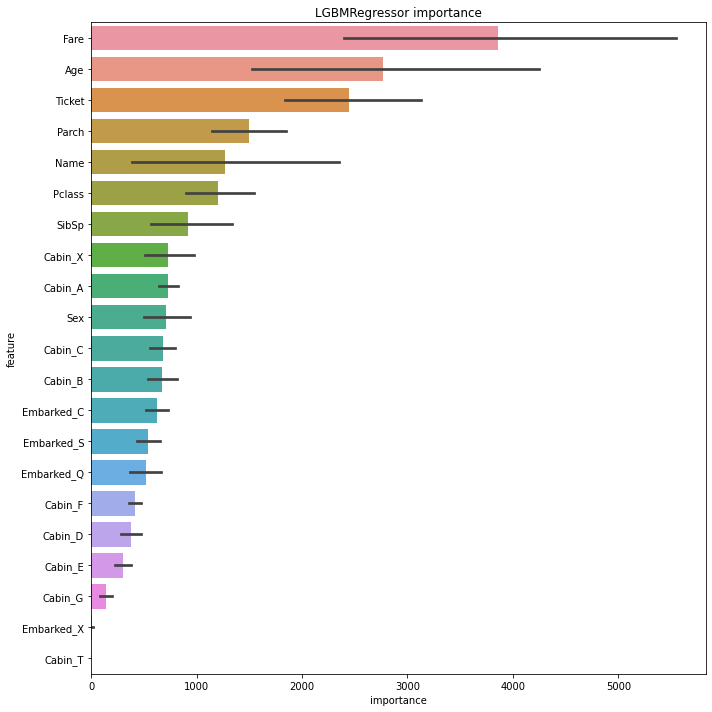

In [12]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

# CatBoost

In [14]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [15]:
ctb_full_preds = []
for SEED in range(N_ITERS):
    ctb_oof = np.zeros(train_df.shape[0])
    ctb_preds = np.zeros(test_df.shape[0])
    feature_importances = pd.DataFrame()

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
        print(f"===== FOLD {fold} =====")
        oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
        preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

        X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
        X_train = apply_noise(X_train)
        X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
        X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)

        model = ctb.CatBoostClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  use_best_model=True,
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  verbose=VERBOSE
                  )

        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = X_test.columns.to_list()
        fi_tmp["importance"] = model.get_feature_importance()
        fi_tmp["fold"] = fold
        fi_tmp["seed"] = SEED
        feature_importances = feature_importances.append(fi_tmp)

        ctb_oof[oof_idx] = model.predict(X_valid)
        ctb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)

        acc_score = accuracy_score(y_valid, np.where(ctb_oof[oof_idx]>0.5, 1, 0))
        print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

    acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(ctb_oof>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====")
    ctb_full_preds.append(ctb_preds)
ctb_full_preds = np.stack(ctb_full_preds, axis=1)

===== FOLD 0 =====
0:	learn: 0.6878762	test: 0.6881359	best: 0.6881359 (0)	total: 26.6ms	remaining: 26.5s
100:	learn: 0.4830511	test: 0.5064645	best: 0.5064645 (100)	total: 1.57s	remaining: 14s
200:	learn: 0.4547739	test: 0.4925269	best: 0.4925269 (200)	total: 3.4s	remaining: 13.5s
300:	learn: 0.4468870	test: 0.4915453	best: 0.4915160 (293)	total: 4.88s	remaining: 11.3s
400:	learn: 0.4428716	test: 0.4919337	best: 0.4915130 (307)	total: 6.39s	remaining: 9.55s
bestTest = 0.4915130015
bestIteration = 307
Shrink model to first 308 iterations.
===== ACCURACY SCORE 0.775492 =====

===== FOLD 1 =====
0:	learn: 0.6878566	test: 0.6881792	best: 0.6881792 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.4834072	test: 0.5071738	best: 0.5071738 (100)	total: 1.48s	remaining: 13.2s
200:	learn: 0.4554784	test: 0.4925115	best: 0.4925115 (200)	total: 2.94s	remaining: 11.7s
300:	learn: 0.4476588	test: 0.4913804	best: 0.4913804 (300)	total: 4.4s	remaining: 10.2s
400:	learn: 0.4437202	test: 0.4912121	best:

### Feature importance

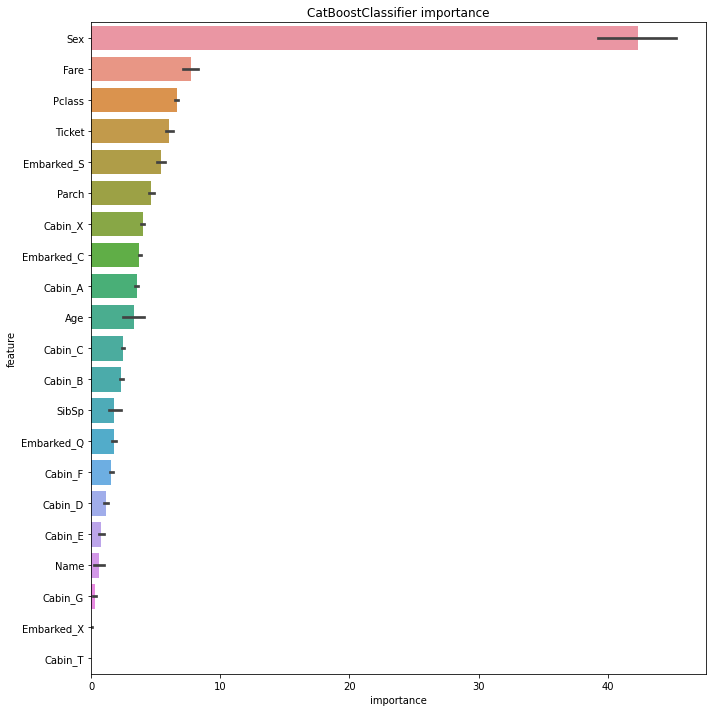

In [16]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

# DecisionTreeModel

In [17]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator=classifier,
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    n_jobs=-1)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [18]:
dtm_full_preds = []
for SEED in range(N_ITERS):
    dtm_oof = np.zeros(train_df.shape[0])
    dtm_preds = np.zeros(test_df.shape[0])
    feature_importances = pd.DataFrame()

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
        print(f"===== FOLD {fold} =====")
        oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
        preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

        X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
        X_train = apply_noise(X_train)
        X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
        X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)

        model = DecisionTreeClassifier(
            max_depth=best_parameters['max_depth'],
            min_samples_leaf=best_parameters['min_samples_leaf'],
            random_state=SEED
        )
        model.fit(X_train, y_train)

        dtm_oof[oof_idx] = model.predict(X_valid)
        dtm_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)

        acc_score = accuracy_score(y_valid, np.where(dtm_oof[oof_idx]>0.5, 1, 0))
        print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

    acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(dtm_oof>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====")
    dtm_full_preds.append(dtm_preds)
dtm_full_preds = np.stack(dtm_full_preds, axis=1)

===== FOLD 0 =====
===== ACCURACY SCORE 0.766660 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.768746 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.765781 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.767629 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.781782 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.764788 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.769454 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.772060 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.765107 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.766466 =====

===== ACCURACY SCORE 0.768850 =====
===== FOLD 0 =====
===== ACCURACY SCORE 0.767859 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.775030 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.762052 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.766740 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.776062 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.768062 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.761130 =====

===== FOLD 7

### Plot tree

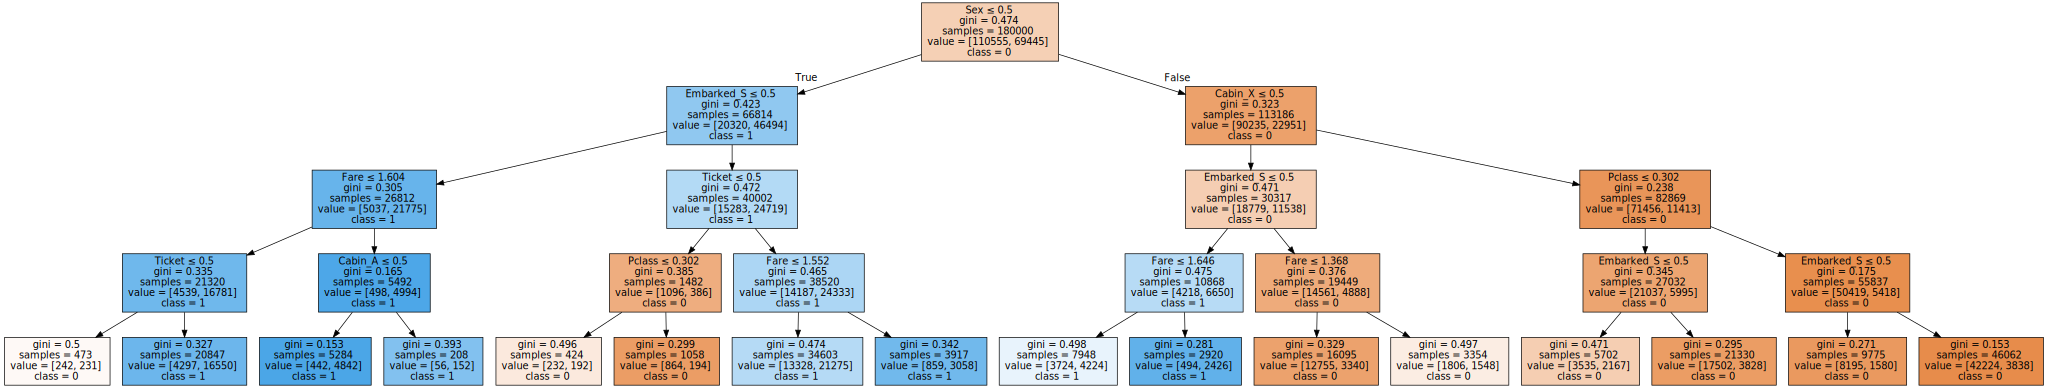

In [19]:
# plot tree
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    filled=True,
    rounded=False,
    special_characters=True,
    precision=3
)
graph = graphviz.Source(dot_data)
graph 

# Ensemble

In [20]:
submission[['submit_lgb_{}'.format(i) for i in range(N_ITERS)]] = np.where(lgb_full_preds>0.5, 1, 0)
submission[['submit_ctb_{}'.format(i) for i in range(N_ITERS)]] = np.where(ctb_full_preds>0.5, 1, 0)
submission[['submit_dtm_{}'.format(i) for i in range(N_ITERS)]] = np.where(dtm_full_preds>0.5, 1, 0)

In [21]:
submission.head()

,PassengerId,Survived,submit_lgb_0,submit_lgb_1,submit_lgb_2,submit_lgb_3,submit_lgb_4,submit_lgb_5,submit_lgb_6,submit_lgb_7,...,submit_dtm_20,submit_dtm_21,submit_dtm_22,submit_dtm_23,submit_dtm_24,submit_dtm_25,submit_dtm_26,submit_dtm_27,submit_dtm_28,submit_dtm_29
0,100000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,100002,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,100003,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100004,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [22]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0     61859
90    29456
30     1451
60      891
89      409
      ...  
68       16
4        16
69       14
34       14
65       13
Length: 91, dtype: int64